# Permutation test for unpaired or independent samples data

We will now look at the case of unpaired data. This is data in which we wish to compare two groups but there are no particular links between individuals in one group and individuals in another group. 

Examples of unpaired (or independent) data can include :
* a comparison of science and humanities students, or first- and final-year students, where the individuals in each group are distinct.
* Treatment and control groups drawn from different people
* Comparing average heights across two different countries

Because the individuals in each group are distinct, we cannot swap labels *within pairs* (as we did for the paired test). Instead, the permutation procedure for independent samples randomly reassigns group labels *across all observations* while preserving the group sizes. This creates resamples consistent with the null hypothesis of no difference between groups, and lets us build the null distribution of the chosen test statistic (for example, the difference in group means).

### Set up Python libraries

As usual, run the code cell below to import the relevant Python libraries

In [2]:
# Set-up Python libraries - you need to run this but you don't need to change it
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import seaborn as sns
sns.set_theme(style='white')
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Toy example

*[A toy example is an example with a very small dataset, just to show how it works]*


#### Question & design

Suppose we suspect that cat owner eat more yoghurt than dog owners. 

We decide to use a  **independent samples design**, comparing yoghurt consumption between a group of cat owners and an unrelated group of dog owners.

#### Hypotheses

We can state our hypotheses as follows:

$\mathcal{H_o}:$ The difference in the mean number of yoghurts eaten by cat owners and dog owners is zero
* mean(cat owners' yoghurt consumption) - mean(dog owners' yoghurt consumption) = 0

$\mathcal{H_a}:$ Cat owners eat more yoghurt compared to dog owners
* mean(cat owners' yoghurt consumption) > mean(dog owners' yoghurt consumption) = 0


*Note: This is a one-tailed (directional) test because we predict a specific direction (cat owners > dog owners). If you do not have a justified directional prediction, use a two-tailed test instead. Ideally you should choose one- vs two-tailed testing before you look at the data.*

#### Data

We survey five cat owners and four dog owners and ask how many times in the last week they ate yogurt. We obtain the following data:

In [10]:
yog = pd.read_csv('https://raw.githubusercontent.com/jillxoreilly/StatsCourseBook_2024/main/data/yoghurt.csv')
yog

Pet  Yoghurt
0   cat        0
1   cat        7
2   cat        5
3   cat        2
4   cat       13
5   cat        1
6   cat        8
7   cat        6
8   cat        3
9   cat        5
10  dog        0
11  dog        0
12  dog        6
13  dog        4
14  dog        1
15  dog        4
16  dog        3
17  dog        2

Let’s plot the data. In this case a scatterplot isn’t appropriate, because there is no natural way to pair or connect individuals across the two groups (cat owners and dog owners).

Instead, we can use a bar plot showing the mean for each group, and add individual data points (often called a “dot plot” or “strip plot”) on top. This allows us to see both the group averages and the spread of individual responses.

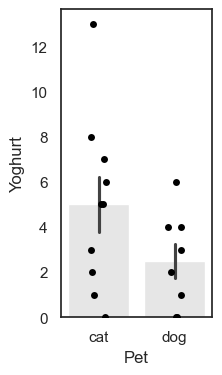

In [15]:
plt.figure(figsize=(9,4))
plt.subplot(1,4,1)
sns.barplot(data=yog, x='Pet', y='Yoghurt', color=[0.9,0.9,0.9], errorbar='se')
sns.stripplot(data=yog, x='Pet', y='Yoghurt', color=[0,0,0]) # this bit plots the dots
plt.show()

We can see that the mean number of yoghurts eaten is higher for cat owners (the bar for cats is higher than the bar for dog), but this difference might be influenced by one particularly enthusiastic yoghurt-eating cat owner.
                                                                                                                     
### Test statistic

To analyse these data, we again need to summarise the difference in yoghurt consumption with a single number, a **test statistic**. Here, our test statistic is the difference in group means:

<tt>mean(Cat owners) - mean(Dog owners))</tt>

This value captures, on average, how many more yoghurts cat owners ate compared to dog owners, and to calculate this you can use the following code:

In [19]:
cat_owners = yog.query('Pet=="cat"')
dog_owners = yog.query('Pet=="dog"')

print(cat_owners.Yoghurt.mean() - dog_owners.Yoghurt.mean())

2.5


Note: here we need to use `.query` to seperately select the rows of cat and dog owners. Once we've done that we can select the column we are interested in (Yoghurt) and calculate the mean using `.mean()`. You can do this in two steps (as above) or one step (as below):

In [20]:
print(yog.query('Pet == "cat"').Yoghurt.mean() - yog.query('Pet == "dog"').Yoghurt.mean())

2.5


On average, cat owners eat yoghurt 2.5 more times per week than dog owners. Possibly because cats stealing yoghurt are cute.

### Is the result statistically significant? 

Even if there were no true difference in yoghurt consumption between pet types, we wouldn't expect the difference in sample means to be *exactly zero*. Just by chance, a random sample of cat and dog owners will sometimes show higher yoghurt consumption for cat owners, and sometimes for dog owners.

So we ask:

***Is it plausible that the difference we observed (2.5 additional yoghurts per week for cat owners) arose purely by chance in a situation in which there is truly no pet-based difference in yoghurt consumption***

In other words, could this happen if the null hypothesis were true?

Under the null, it would simply be random which individuals end up labelled as “cat owners” and which as “dog owners.”

### Permutation

To work out how unusual our observed difference in mean yoghurt consumption between cat and dog owners (2.5) is, we carry out a permutation test. Again, the idea is to shuffle the pet labels and see what kinds of mean differences would occur just by chance (i.e. the null distribution).

For each resample:


Which ones switch changes from resample to resample.

Compute the test statistic:

1. **Randomly reassign people to group:** Shuffle the data around to create a new sample in which, we we randomly decide who gets which label, *cat* or *dog* while keeping the group sizes the same (10 “cat owners” and 8 “dog owners”).
2. **Calculate the difference of the means:** <tt>mean(Cat owners)-mean(Dog owners)</tt>.
3. **Repeat steps 1 & 2 thousands of times** this will create a distribution in which the difference between cat owners and dog owners truly was zero. Now we can ask on what proportion of random resamples we get a values of <tt>mean(Cat owners)-mean(Dog owners)</tt> at least as large as our observed difference, 2.5.

Within each resample, some individuals will retain their true pet identity, and some will be relabelled; which individuals are which will differ between resamples.

In this case as data are unpaired, we don't need to preserve pared realationships - ie we can swap the pet-labels for any two people in the sample of 18. However, we do still want to preserve the non-pet-based features of the dataset, namely the sample sizes (10 cat owners and 8 dog owners).

Shuffling within our sample of 18 will also preserve the overall features of the dataset:

**Non pet-based effects (to be preserved):**
* Most people eat yoghurt less than once a day
* Some people eat loads of yoghurt
    * ie the distriution of differences has positive skew 

**Potential pet-based effects (to be "shuffled out")**:
* The number of times yoghurt is eaten tends to be higher for cat owners
* The outlier individual who ate loads of yoghurt was a cat owner



### Run the simulation

To generate new simulated datasets, we will shuffle around the datapoints in our original dataset. 

Which ones can we shuffle?

* We assume there are no pet-based differences, so we can swap the pet-labels for any individuals in the sample
* We stick to the original sample sizes, ie 10 people should always be labelled as cat-owners and 8 as dog-owners

Conceptually, we would achieve this by randomly re-ordering the 18 values in the 'Yogurt' column so that a different 10 fall into rows laelled 'cat'

### Visualizing randoms shuffles in the unpaired data

Let's see how the difference of means changes over a few random shuffles.

Below I generate 4 random shuffles of our yoghurt data (in which individuals are randomly relabelled as cat- or dog-owners, maintaining the correct number of cat- and dog-owners), and plot the outcomes:

<img src= "https://raw.githubusercontent.com/jillxoreilly/StatsCourseBook_2024/main/images/MT_wk5_4PermutationsInd.png" width="80%" />


Note that **each individual can move between the 'cat' and 'dog' group at random**, but there are always 10 people in the 'cat' group and 8 people in the 'dog' group.

You can see that the difference of means (difference in heights of the bars) depends on whether more of the high-yoghurt individuals are assigned as cat owners, and also depends quite a lot on which group the 13-yoghurt individual ends up in.

Below is some code that will randomly shuffle our `Yoghurt` column, but keep the `Pet` column in tact. What this is essentially doing is radomly shuffle the label ('Cat'/'Dog') for each person in the data set. Run the code below several times to see what happens to the plot and the test statistic:

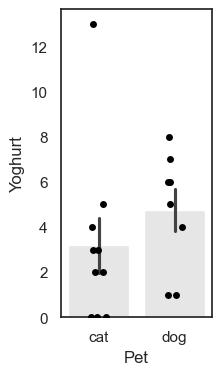

-1.5499999999999998


In [47]:
perm = pd.read_csv('https://raw.githubusercontent.com/jillxoreilly/StatsCourseBook_2024/main/data/yoghurt.csv')

#Randomise the order of the Yoghurt column
perm.Yoghurt = perm.Yoghurt.sample(len(perm), replace = False).to_list()

#Plot
plt.figure(figsize=(9,4))
plt.subplot(1,4,1)
sns.barplot(data=perm, x='Pet', y='Yoghurt', color=[0.9,0.9,0.9], errorbar='se')
sns.stripplot(data=perm, x='Pet', y='Yoghurt', color=[0,0,0]) # this bit plots the dots
plt.show()

# Compute the test statistic for THIS permutation
test_stat = perm.query('Pet == "cat"').Yoghurt.mean() - perm.query('Pet == "dog"').Yoghurt.mean()
print(test_stat)

## Run Many shuffles

To get an estimate of how likely it is to get a test statistic of 2.5 due to chance, we need to run a *lot* of shuffles. Here we can loop through our desired number of permutations, repeating this shuffling process each time and recalculaing the test statistic. 

<Axes: ylabel='Count'>

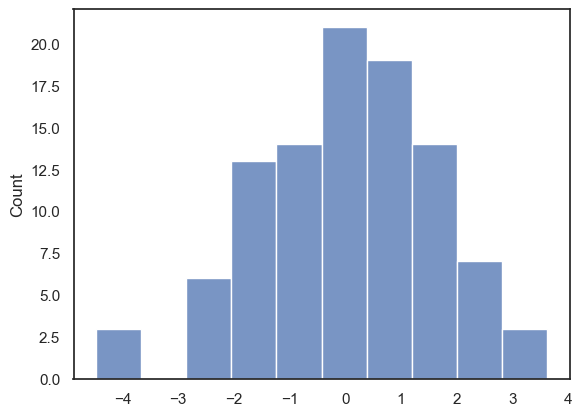

In [48]:
nReps = 100
perm_tests = np.empty(nReps)

for i in range(nReps):
    # Make a copy so we do not overwrite the original data
    perm = pd.read_csv('https://raw.githubusercontent.com/jillxoreilly/StatsCourseBook_2024/main/data/yoghurt.csv')

    #Randomise the order of the Yoghurt column
    perm.Yoghurt = perm.Yoghurt.sample(len(perm), replace = False).to_list()

    perm_tests[i] = perm.query('Pet == "cat"').Yoghurt.mean() - perm.query('Pet == "dog"').Yoghurt.mean()

sns.histplot(data=perm_tests, bins = 10)

With 100 permutations you can already see the null distribution taking shape. Most of the permutations center around a small difference between the two group as expected, however how often do we see a difference at least as large as we observed in data set (i.e., 2.5)? To increase our confidence we probably want to run even more permutations!


## Run 10,000 shuffles

To get a fine-grained estimate of how likely it is to get a test statistic of 2.5 due to chance, we run a *lot* of shuffles - say 10,000.

We can do this using a function from the library `scipy.stats`, called `scipy.stats.permutation_test()`

This will have a few advantages. First, the inbuilt function is much faster and therefore we can easily increase the number of permutattions without costing too much time. The function also provides some additional output which we will take a closer look at below. Start by running the code block below - don't worry too much about the syntax we'll dive into that later...

In [64]:
def dMeans(x, y):
    return np.mean(x)-np.mean(y)

results = stats.permutation_test((yog.query('Pet == "cat"').Yoghurt, yog.query('Pet == "dog"').Yoghurt), dMeans, 
                                  permutation_type='independent', alternative='greater', n_resamples=10000)
print(results)

PermutationTestResult(statistic=np.float64(2.5), pvalue=np.float64(0.0663933606639336), null_distribution=array([-1.1  ,  0.925,  0.7  , ..., -2.9  ,  0.925, -2.225],
      shape=(10000,)))



The results are displayed below the code box; there are number of outputs from the test (contained in the parentheses)

* **statistic** - the test statistic (mean difference) from our actual data, ie 2.5
* **pValue** - the proportion of shuffles in which a result greater than 2.5 was obtained (due to chance)
* **null distribution** - this contains all 10,000 difference of mean values, for the 10,000 shuffles


### The Null Distribution

The **null distribution** is the set of 10,000 values we get for the difference of mean yoghurt consumption for (cat owners - dog owners), from our 10,000 shuffles (the equivalent of the red numbers on the 4-permutation example above)

Let's plot the null distribution in a histogram we will mark the test statistic from our actual data with a red dotted line:

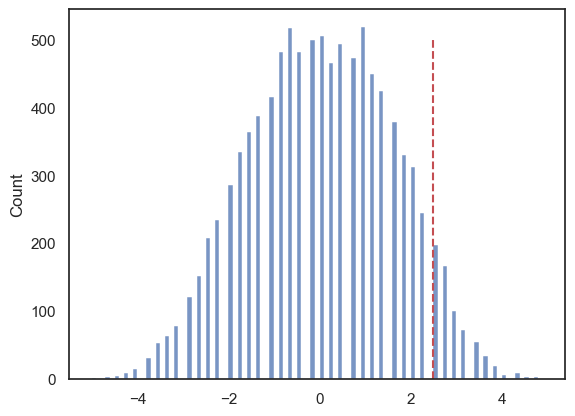

In [65]:
sns.histplot(results.null_distribution, bins=np.arange(-5,5,0.1))
plt.plot([results.statistic,results.statistic],[0,500], 'r--')
plt.show()

The histogram looks a bit spikey because this dataset is very small and contains several repeated values.
As a result, there are only a limited number of possible values that the mean yoghurt consumption of a group of 10 (cat owners) or a group of 8 (dog owners) can take.

Even so, we can see that the observed difference between cat and dog owners’ mean yoghurt consumption (+2.5) is unusual, but not completely extreme, within this permutation distribution.

### The $𝑝$-value¶

We can calculate the exact proportion of cases in which the difference of means for cat- minus dog-owners exceeds the value we observed in our original sample, 2.5. 

In [66]:
# check which values is the null distribution are greater than 4.6 and code as 1/0
# then use the numpy function np.mean() to get the avergae of those ones and zeros (ie he proportion of 1s)
print(np.mean(results.null_distribution >= 2.5))

0.0663


This proportion is ~0.06 or ~6% (Remember the exact value will differ slightly each time you run the permutation...)

This tells us that if we simulate a situation in which pet ownership does not determine the number of times yoghurt is eaten (but preserving some other important features of the dataset like the high skew), there is still higher than a 5% chance that we would get an apparent pet-based difference as large as the one we observed in our 'real' data.

The probability that the test statistic (in this case, the difference in mean times yoghurt is eaten) would be observed if the null hypothesis were true, is sometimes called the $𝑝$-value.

Our permutation test shows that the $𝑝$-value associated with the observed difference of means is 0.06 or 6%.

The result is considered statistically significant if $𝑝$ is smaller than some predetermined level, known as $\alpha$. Usually $\alpha=0.05$ or $\alpha=0.01$ is used; this result is not quite significant if $\alpha=0.05$ but not significant if $\alpha=0.01$. 

## Syntax of `stats.permutation_test()`

Let's have a look at the Python code to run the permutation test.

Firstly, we had to give the function `stats.permutation_test()` our two samples. In this case, the data are in 'long form', ie the pet category is defined in one column of the dataset, so cat owners and dog owners are in different rows. We therefore identify our categories useing `df.query()` with the column we want (<tt>Yoghurt</tt>) tacked on the end:

`(yog.query('Pet == "cat"').Yoghurt, yog.query('Pet == "dog"').Yoghurt)`

Secondly, to tell `stats.permutation_test()` the test statistic we want to get the null distribution of, we had to pass it a *function* that calculates that test statistic. We created that function, `dMeans()`, using a function definition, before running the permutation test


### Arguments

When running the permutation test, we have to specify some arguments

* **n_resamples** the number of shuffles to do.
* **alternative** - whether to do a one-tailed test (and in whcih direction: 'greater' counts how many shuffles result in test statistic values greater than the one obtained from unshuffled data) or a two tailed test
* **permutation_type** - pairings, samples, or independent. These are for test of correlation, paired data and unpaired data respectively.

Here we are testing for a difference of means in *independent* (unpaired) samples, so we choose `permutation_type='independent'` - this randomly shuffles all the datapoints and assignes them randomly to the groups cat/dog.

## Recap

To run a permutation test on unpaired data, we mixed up all the individuals in the sample regardless of category (pet ownership), and randomly split them into two groups. We kept the original group sizes (10 and 8 in this case), as we want to retain the characteristics of the original dataset that one group is larger

For each shuffle we calculated the mean yoghurt consuption for each 'pet' group. 

Permutation testing in this way gives us a null distribution for the difference of means. Values of difference of means that occur rarely in the null distribution are considered statistically significant.
    
To run the permutation test with <tt>scipy.stats</tt> we need the option `permutation_type='independent'`